<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main goal of natural language processing (NLP) is to derive information from natural language.

Natural language is a broad term but you can consider it to cover any of the following:

Text (such as that contained in an email, blog post, book, Tweet)
Speech (a conversation you have with a doctor, voice commands you give to a smart speaker)

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6fb52a0b-6d93-170a-8763-314682f30dbd)


In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-20 07:54:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-20 07:54:41 (70.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

#Download a text dataset

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-06-20 07:54:50--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.31MB/s    in 0.4s    

2024-06-20 07:54:51 (1.31 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled=train_df.sample(frac=1,random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many samples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
len(train_df)-5

7608

In [10]:
# Let's visualize some random training examples
import random
random_index=random.randint(0,len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/rkU0IDM6aQ

---

Target: 1 (real disaster)
Text:
The Latest: More homes razed by #NorthernCalifornia wildfire http://t.co/mONiJJth7V #ZippedNews http://t.co/0yXBB5dzw5

---

Target: 0 (not real disaster)
Text:
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????

---

Target: 1 (real disaster)
Text:
#?? #?? #??? #??? Suicide bomber kills 15 in Saudi security site mosque - Reuters  http://t.co/txg7K2DO9v

---

Target: 0 (not real disaster)
Text:
That hellfire song from the hunchback of notre dame reminds me a lot of my house

---



#Split data into training and validation sets


In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                        train_df_shuffled["target"].to_numpy(),
                                                                        test_size=0.1, # dedicate 10% of samples to validation set
                                                                        random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:

**Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:

Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.

Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.

Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.

**Embeddings **- An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:

Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.

Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                  standardize="lower_and_strip_punctuation", # how to process text
                                  split="whitespace",# how to split tokens
                                  ngrams=None, # create groups of n-words?
                                  output_mode="int", # how to map tokens to numbers
                                  output_sequence_length=None # how long should the output sequence of tokens be?
                                  )

In [15]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
# Setup text vectorization with custom variables
max_vocab_length=10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode='int',
                                  output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the training text

text_vectorizer.adapt(train_sentences)

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from the training dataset and tokenize it

random_sentance=random.choice(train_sentences)
print(f"original text:\n{random_sentance}\
      \n\n Vectorize version:")
text_vectorizer([random_sentance])

original text:
Businesses are deluged with invokces. Make yours stand out with colour or shape.and it's likely to rise to the top of the pay' pile.      

 Vectorize version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1037,   22,  655,   14,    1,  144,  829,  807,   36,   14, 1423,
          53, 8597,   37, 1008]])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab=text_vectorizer.get_vocabulary()
top_5_words=words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


#Creating an Embedding using an Embedding Layer

We can see what an embedding of a word looks like by using the tf.keras.layers.Embedding layer.

Creating an Embedding using an Embedding Layer
We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. 1 = I, 2 = love, 3 = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the tf.keras.layers.Embedding layer.

The main parameters we're concerned about here are:

input_dim - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).

output_dim - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.

embeddings_initializer - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.

input_length - Length of sequences being passed to embedding layer.


In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding=layers.Embedding(input_dim=max_vocab_length, # set input shape
                           output_dim=128, #set size of embeding vector
                           embeddings_initializer="uniform",  # default, intialize randomly
                           input_length=max_length, #how long is each input
                           name="embedding_1"
                           )
embedding

In [22]:
# Get a random sentence from training set

random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
New post: Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/LWDcrPEhTN      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01311132, -0.00694573,  0.04712573, ...,  0.04268738,
         -0.00640526,  0.02085637],
        [-0.01920179, -0.01552962, -0.02661518, ..., -0.02392439,
          0.02435074, -0.01097099],
        [ 0.03966712, -0.0136557 , -0.02309773, ..., -0.03839279,
          0.02676389, -0.03677158],
        ...,
        [-0.04155067,  0.01046567, -0.02592525, ...,  0.03809782,
         -0.02176886, -0.02483304],
        [-0.02375531, -0.01342513, -0.02614443, ..., -0.00865128,
         -0.02213148,  0.02251276],
        [ 0.01714079, -0.04455493, -0.0480032 , ..., -0.03244596,
          0.02203718,  0.01771648]]], dtype=float32)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.01311132, -0.00694573,  0.04712573,  0.00565231,  0.01537093,
        0.03343276,  0.00540742,  0.02275652, -0.0252709 ,  0.0486202 ,
        0.04087443,  0.01340082, -0.0279729 ,  0.01232881, -0.01680803,
       -0.0400799 , -0.03162615,  0.04075149,  0.02242536, -0.03603273,
        0.01815699,  0.00742736, -0.0347738 ,  0.03731975,  0.03921935,
       -0.04393845, -0.03314265, -0.01684133, -0.01181159,  0.0102681 ,
        0.01679875,  0.03555626, -0.02826328, -0.00973962, -0.0405543 ,
        0.02578907,  0.00237634,  0.02119673, -0.00024282,  0.00709919,
        0.03247264, -0.00531639, -0.01987795, -0.02015642,  0.01807738,
        0.0205592 ,  0.0051553 ,  0.01836104, -0.0453831 , -0.04438313,
        0.01385403,  0.0306641 , -0.01553025,  0.00121744, -0.02188406,
       -0.00614414,  0.03342906, -0.04869456, -0.02430252, -0.03913349,
       -0.00345343,  0.01540238, -0.03249619, -0.02518258,  0.01873494,
        0.049610

#Modelling a text dataset

**Model 0**: Naive Bayes (baseline)

**Model 1**: Feed-forward neural network (dense model)

**Model 2**: LSTM model

**Model 3**: GRU model

**Model 4**: Bidirectional-LSTM model

**Model 5**: 1D Convolutional Neural Network

**Model 6**: TensorFlow Hub Pretrained Feature Extractor

**Model 7**: Same as model 6 with 10% of training data


#Model 0: Getting a baseline

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm. This was chosen via referring to the Scikit-Learn machine learning map.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0=Pipeline([
                  ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                  ("clf", MultinomialNB()) #model the text
                  ])

## Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score=model_0.score(val_sentences,val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

#Creating an evaluation function for our model experiments

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#Model 1: A simple dense model

In [29]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [30]:
#Build model with the Functional API
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x=text_vectorizer(inputs) #tunrn the input text into number
x=embedding(x) #create an embedding of the numerized nubers
x=layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs=layers.Dense(1,activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1=tf.keras.Model(inputs, outputs, name="model_1_dense") #construct the model

In [31]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [32]:
#Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [33]:
# Fit the model
model_1_history=model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in mode
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                   experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240620-075500
Epoch 1/5
215/215 [==============================] - 10s 38ms/step - loss: 0.6088 - accuracy: 0.6927 - val_loss: 0.5354 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4400 - accuracy: 0.8202 - val_loss: 0.4690 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3453 - accuracy: 0.8610 - val_loss: 0.4591 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2838 - accuracy: 0.8929 - val_loss: 0.4644 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2370 - accuracy: 0.9130 - val_loss: 0.4770 - val_accuracy: 0.7861


In [34]:
# Check the results
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4770 - accuracy: 0.7861


[0.4769810140132904, 0.7860892415046692]

In [35]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.05700063,  0.04258178, -0.04655806, ...,  0.02365355,
         -0.02958321,  0.00370493],
        [ 0.03993656, -0.03538571, -0.01405153, ..., -0.00322317,
         -0.050201  ,  0.01672583],
        [-0.06412557,  0.04191266,  0.00499223, ...,  0.00891351,
          0.0074701 , -0.01740377],
        ...,
        [ 0.0377746 ,  0.04868697,  0.03430334, ..., -0.02488352,
          0.02032207, -0.01382881],
        [-0.0126989 ,  0.07928749, -0.04111295, ..., -0.00966614,
         -0.05003731, -0.0802687 ],
        [-0.01474545,  0.09296418, -0.03861047, ..., -0.0406886 ,
         -0.11316488, -0.08501152]], dtype=float32)>]

In [36]:
embeded_weights=model_1.get_layer("embedding_1").get_weights()[0]
print(embeded_weights.shape)

(10000, 128)


In [37]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [38]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [39]:
# Make predictions (these come back in the form of probabilities)

model_1_pred_probs=model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.41497236],
       [0.74571717],
       [0.9978331 ],
       [0.10802084],
       [0.10571397],
       [0.9329772 ],
       [0.91636616],
       [0.9928514 ],
       [0.96953434],
       [0.26101926]], dtype=float32)

In [40]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds=tf.squeeze(tf.round(model_1_pred_probs)) #squeeze remove single dimensions
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [41]:
# Calculate model_1 metrics
model_1_results=calculate_results(y_true=val_labels,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [42]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values()))>np.array(list(baseline_results.values()))

array([False, False, False, False])

In [43]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key,value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


#Visualizing learned embeddings

Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:

Go to http://projector.tensorflow.org/

Click on "Load data"

Upload the two files you downloaded (embedding_vectors.tsv and embedding_metadata.tsv)

Explore

Optional: You can share the data you've created by clicking "Publish"


In [44]:
# Get the vocabulary from the text vectorization layer
words_in_vocab=text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0:
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

#Recurrent Neural Networks (RNN's)
The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

ecurrent neural networks can be used for a number of sequence-based problems:

One to one: one input, one output, such as image classification.

One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).

Many to one: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).

Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:

Long short-term memory cells (LSTMs).

Gated recurrent units (GRUs).

Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).



 Resources:

MIT Deep Learning Lecture on Recurrent Neural Networks - explains the background of recurrent neural networks and introduces LSTMs. https://youtu.be/SEnXr6v2ifU

The Unreasonable Effectiveness of Recurrent Neural Networks by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Understanding LSTMs by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.
https://colah.github.io/posts/2015-08-Understanding-LSTMs/


#Model 2: LSTM

tensorflow.keras.layers.LSTM().

Our model is going to take on a very similar structure to model_1:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [46]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")
#Create LSTM model
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x=layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_LSTM")





(None, 15, 128)
(None, 64)


In [47]:
#Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [49]:
#Fit the model
model_2_history=model_2.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240620-075520
Epoch 1/5
215/215 [==============================] - 11s 36ms/step - loss: 0.5099 - accuracy: 0.7434 - val_loss: 0.4558 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3171 - accuracy: 0.8729 - val_loss: 0.5186 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2203 - accuracy: 0.9168 - val_loss: 0.5702 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1578 - accuracy: 0.9453 - val_loss: 0.6001 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1129 - accuracy: 0.9602 - val_loss: 0.7695 - val_accuracy: 0.7638


In [50]:
# Make predictions on the validation dataset
model_2_pred_probs=model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]  # view the first 10

24/24 [==============================] - 0s 4ms/step


((762, 1),
 array([[0.03075317],
        [0.73538077],
        [0.9992055 ],
        [0.08142685],
        [0.00633892],
        [0.99943703],
        [0.7743996 ],
        [0.9995449 ],
        [0.9995498 ],
        [0.19433387]], dtype=float32))

In [51]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds=tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.37795275590551,
 'precision': 0.7640630933275061,
 'recall': 0.7637795275590551,
 'f1': 0.762372083327101}

#Model 3: GRU
The GRU cell has similar features to an LSTM cell but has less parameters.

The architecture of the GRU-powered model will follow the same structure we've been using:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [53]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding=layers.Embedding(input_dim=max_vocab_length,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=max_length,
                                   name="embedding_3")
#Build an RNN using the GRU cell
inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x=layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs=layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [54]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240620-075542
Epoch 1/5
215/215 [==============================] - 11s 39ms/step - loss: 0.5240 - accuracy: 0.7323 - val_loss: 0.4533 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3173 - accuracy: 0.8686 - val_loss: 0.4897 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2175 - accuracy: 0.9181 - val_loss: 0.5634 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1560 - accuracy: 0.9439 - val_loss: 0.6173 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1177 - accuracy: 0.9596 - val_loss: 0.6111 - val_accuracy: 0.7703


In [56]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.41077238],
        [0.90372056],
        [0.9964508 ],
        [0.12533411],
        [0.01481943],
        [0.98867375],
        [0.7196669 ],
        [0.99677604],
        [0.9966343 ],
        [0.50826496]], dtype=float32))

In [57]:
# Convert prediction probabilities to prediction classes
model_3_preds=tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [58]:
# Calcuate model_3 results
model_3_results=calculate_results(y_true=val_labels,
                                  y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7700604729059295,
 'recall': 0.7703412073490814,
 'f1': 0.7696090403305004}

In [59]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


#Model 4: Bidirectonal RNN model

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

In [60]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding=layers.Embedding(input_dim=max_vocab_length,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=max_length,
                                   name="embedding_4")
# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)  # Reuse embedding layer if desired

# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer


outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [61]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [62]:

model_4.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [63]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240620-075605
Epoch 1/5
215/215 [==============================] - 15s 45ms/step - loss: 0.5110 - accuracy: 0.7446 - val_loss: 0.4627 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3148 - accuracy: 0.8711 - val_loss: 0.5263 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2130 - accuracy: 0.9194 - val_loss: 0.5693 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1465 - accuracy: 0.9504 - val_loss: 0.6494 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1072 - accuracy: 0.9634 - val_loss: 0.7204 - val_accuracy: 0.7612


In [64]:
model_4_pred_probs=model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.0407886 ],
       [0.852614  ],
       [0.9994081 ],
       [0.14619705],
       [0.0030568 ],
       [0.9968867 ],
       [0.92972845],
       [0.9996215 ],
       [0.99964094],
       [0.34344313]], dtype=float32)

In [65]:
# Convert prediction probabilities to labels
model_4_preds=tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [66]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.11548556430446,
 'precision': 0.7607410097018414,
 'recall': 0.7611548556430446,
 'f1': 0.760689014360106}

In [67]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.12, Difference: -3.15
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


#Convolutional Neural Networks for Text

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

A typical CNN architecture for sequences will look like the following:

Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)



#Model 5: Conv1D

In [68]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding=layers.Embedding(input_dim=max_vocab_length,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=max_length,
                                   name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=model_5_embedding(x)
x=layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x=layers.GlobalAveragePooling1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs=layers.Dense(1, activation="sigmoid")(x)
model_5=tf.keras.Model(inputs,outputs, name="model_5_Conv1D")

In [69]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)              

In [70]:
#Compile the model

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240620-075632
Epoch 1/5
215/215 [==============================] - 11s 38ms/step - loss: 0.5382 - accuracy: 0.7314 - val_loss: 0.4661 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3383 - accuracy: 0.8583 - val_loss: 0.5057 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2343 - accuracy: 0.9114 - val_loss: 0.5777 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1700 - accuracy: 0.9350 - val_loss: 0.6731 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1271 - accuracy: 0.9512 - val_loss: 0.7747 - val_accuracy: 0.7546


In [72]:
#MAke predictions
model_5_pred_probs=model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.45824274],
       [0.8242249 ],
       [0.99999785],
       [0.01698354],
       [0.02406665],
       [0.9897271 ],
       [0.796127  ],
       [0.99967504],
       [0.9999981 ],
       [0.18774483]], dtype=float32)

In [73]:
# Convert model_5 prediction probabilities to labels
model_5_preds=tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [74]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.45931758530183,
 'precision': 0.7543596436293261,
 'recall': 0.7545931758530183,
 'f1': 0.7535158648005912}

In [75]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 75.46, Difference: -3.81
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


#Using Pretrained Embeddings (transfer learning for NLP)

A common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.
We're going to be using the Universal Sentence Encoder from TensorFlow Hub


#Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.


In [76]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4

import tensorflow_hub as hub
embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples=embed([sample_sentence,
                     "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [77]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the hub.KerasLayer class.

🔑 Note: Due to the size of the USE TensorFlow Hub module, it may take a little while to download. Once it's downloaded though, it'll be cached and ready to use. And as with many TensorFlow Hub modules, there is a "lite" version of the USE which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your available compute power, the lite version may be better for your application use case.

In [78]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      input_shape=[], # shape of inputs coming to our model
                                      dtype=tf.string, # data type of inputs coming to the USE layer
                                      trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                      name="USE")

In [79]:
# Create model using the Sequential API
model_6=tf.keras.Sequential([
    sentence_encoder_layer, # take in sentences and then encode them into an embedding
    layers.Dense(64,activation="relu"),
    layers.Dense(1, activation="sigmoid")
],name="model_6_USE")


In [80]:
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [81]:
# Train a classifier on top of pretrained embeddings
model_6_history=model_6.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240620-075729
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5096 - accuracy: 0.7800 - val_loss: 0.4472 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4153 - accuracy: 0.8136 - val_loss: 0.4355 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4001 - accuracy: 0.8216 - val_loss: 0.4313 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3926 - accuracy: 0.8257 - val_loss: 0.4273 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3864 - accuracy: 0.8283 - val_loss: 0.4297 - val_accuracy: 0.8123


In [82]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.16422297],
       [0.7394691 ],
       [0.98946804],
       [0.19020681],
       [0.72865796],
       [0.6934511 ],
       [0.9826958 ],
       [0.9796625 ],
       [0.9294639 ],
       [0.08451101]], dtype=float32)

In [83]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8155610053499988,
 'recall': 0.8123359580052494,
 'f1': 0.8104722790014789}

In [85]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New precision: 0.82, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


#Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [86]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [87]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [88]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: count, dtype: int64

In [89]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [90]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240620-075755
Epoch 1/5
22/22 [==============================] - 5s 71ms/step - loss: 0.6684 - accuracy: 0.6910 - val_loss: 0.6454 - val_accuracy: 0.7113
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5897 - accuracy: 0.8163 - val_loss: 0.5854 - val_accuracy: 0.7454
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5113 - accuracy: 0.8280 - val_loss: 0.5343 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4482 - accuracy: 0.8353 - val_loss: 0.5040 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4062 - accuracy: 0.8426 - val_loss: 0.4881 - val_accuracy: 0.7690


In [91]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.24471891],
       [0.7636345 ],
       [0.91036445],
       [0.27058625],
       [0.52034646],
       [0.81133085],
       [0.8133594 ],
       [0.841635  ],
       [0.81715727],
       [0.13135105]], dtype=float32)

In [92]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [93]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 76.9028871391076,
 'precision': 0.7735527917281305,
 'recall': 0.7690288713910761,
 'f1': 0.7656200904727405}

In [94]:

# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


#Comparing the performance of each of our models

In [95]:
# Combine model results into a DataFrame
all_model_results=pd.DataFrame({"baseline": baseline_results,
                                "simple_dense": model_1_results,
                                "lstm": model_2_results,
                                "gru": model_3_results,
                                "bidirectional": model_4_results,
                                "conv1d": model_5_results,
                                "tf_hub_sentence_encoder": model_6_results,
                                "tf_hub_10_percent_data": model_7_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,76.377953,0.764063,0.763780,0.762372
gru,77.034121,0.770060,0.770341,0.769609
bidirectional,76.115486,0.760741,0.761155,0.760689
conv1d,75.459318,0.754360,0.754593,0.753516
tf_hub_sentence_encoder,81.233596,0.815561,0.812336,0.810472
tf_hub_10_percent_data,76.902887,0.773553,0.769029,0.765620


In [96]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"]=all_model_results["accuracy"]/100

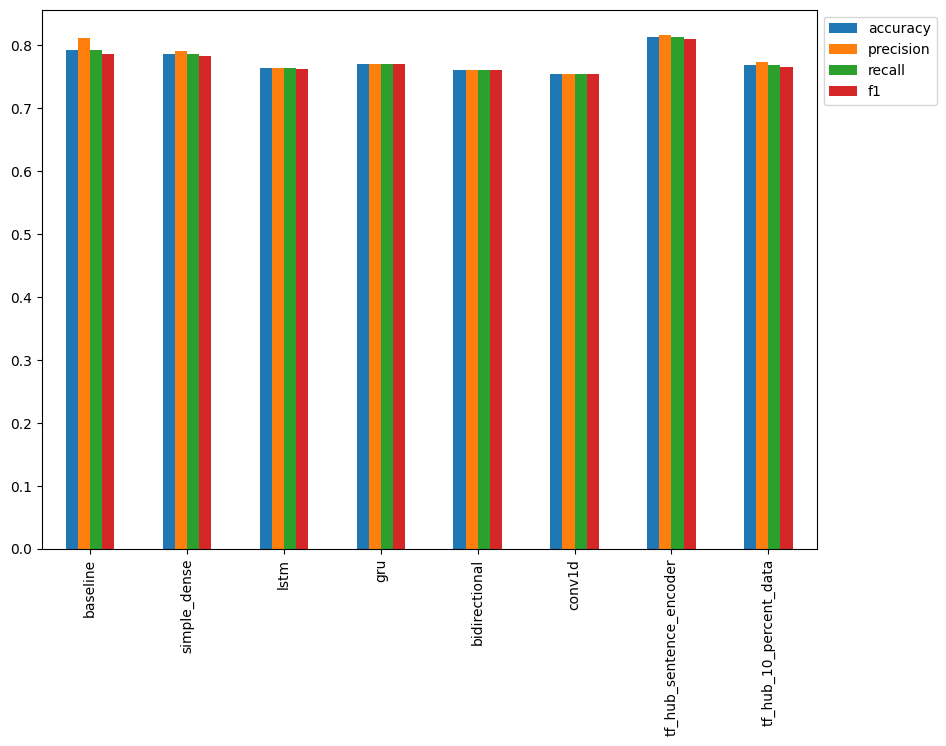

In [97]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

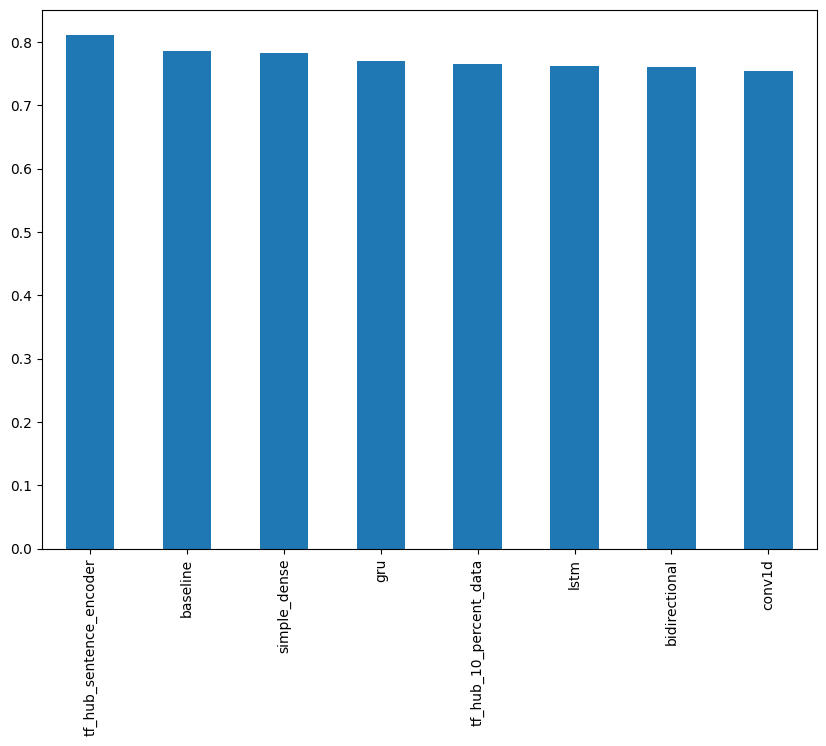

In [98]:
# Sort model results by f1-score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

#Saving and loading a trained model

In [99]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [100]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [101]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 24ms/step - loss: 0.4297 - accuracy: 0.8123


[0.4296927750110626, 0.8123359680175781]

In [102]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [103]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [104]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4297 - accuracy: 0.8123


[0.4296927750110626, 0.8123359680175781]

#Finding the most wrong examples

In [105]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.164223
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.739469
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.989468
3,@camilacabello97 Internally and externally scr...,1,0.0,0.190207
4,Radiation emergency #preparedness starts with ...,1,1.0,0.728658


In [106]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.912616
759,FedEx will no longer transport bioterror patho...,0,1.0,0.870125
628,@noah_anyname That's where the concentration c...,0,1.0,0.857073
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.837441
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.832582
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.814562
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.807454
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.803306
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.799850
567,@RebeccaforReal accepts Wisconsin Emergency Re...,0,1.0,0.777606


In [107]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")


Target: 0, Pred: 1, Prob: 0.9126158356666565
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8701245784759521
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8570734262466431
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8374411463737488
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8325816988945007
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8145620822906494
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pr

In [108]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06804332137107849
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.06751402467489243
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.05943424254655838
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05469304323196411
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05049436539411545
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04625656455755234
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04299893602728844
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqd

#Making predictions on the test dataset

In [109]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 46ms/step
Pred: 0, Prob: 0.25374606251716614
Text:
Admiral Says Public Schools Nationwide Shortchanging Military Kids | http://t.co/g0q0bzBjli http://t.co/rbt3mLhlX7 via @Militarydotcom

----

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.0890326127409935
Text:
I donÛªt want to be rescued either #bot

----

1/1 [==============================] - 0s 37ms/step
Pred: 0, Prob: 0.051911476999521255
Text:
Reddit Will Now Quarantine Offensive Content http://t.co/KDc97PrQcc

----

1/1 [==============================] - 0s 35ms/step
Pred: 1, Prob: 0.545137882232666
Text:
Alabama Home Quarantined Over Possible EbolaåÊCase http://t.co/cGKy5rw9cw

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.11965575069189072
Text:
...@jeremycorbyn must be willing to fight and 2 call a spade a spade. Other wise very savvy piece by @OwenJones84 
http://t.co/fabsyxQlQI

----

1/1 [==============================] - 0s 35ms

#Predicting on Tweets from the wild

In [110]:
# Turn Tweet into string
wild_tweet="Life like an ensemble: take the best choices from others and make your own"

In [111]:
def predict_on_sentence(model,sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob=model.predict([sentence])
  pred_label=tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [112]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=wild_tweet)

1/1 [==============================] - 0s 81ms/step
Pred: 0.0 (not real disaster) Prob: 0.05401068553328514
Text:
Life like an ensemble: take the best choices from others and make your own
